<a href="https://www.kaggle.com/msafi04/predict-icu-mortality-shap?scriptVersionId=82788832" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview
- Build a system for predicting patient deaths in the Intensive Care Unit (ICU) using the large PhysioNet Computing in Cardiology Challenge 2012 dataset.
- For each patient in the dataset, demographic variables and time series of physiological variables were collected during their stay in the ICU.

[Ref](http://modelai.gettysburg.edu/2020/icu/handout_py/index.html)

In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import math, random
from pathlib import Path

from tqdm import tqdm
from glob import glob
import gc

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

from plotly.offline import iplot
#to link plotly to pandas
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline = False, world_readable = True)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, average_precision_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, auc

#from sklearn.ensemble import HistGradientBoostingClassifier

plt.rcParams["figure.figsize"] = (12, 10)
plt.rcParams['axes.titlesize'] = 12
sns.set_palette('Set3')
   
from time import time, strftime, gmtime

print(os.listdir('../input/predict-mortality-of-icu-patients-physionet/'))

start = time()
print(start)

import datetime
print(str(datetime.datetime.now()))

import warnings
warnings.simplefilter('ignore')

['set-a', 'Outcomes-a.txt']
1639970222.8138466
2021-12-20 03:17:02.814048


In [2]:
SEED = 42
def seed_everything(seed = SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

In [3]:
base_dir = '../input/predict-mortality-of-icu-patients-physionet/'

In [4]:
input_files = glob(str(Path(base_dir + 'set-a/set-a/') / "*.txt"))
print(f"Num of training files: {len(input_files)}")
input_files[:10]

Num of training files: 4000


['../input/predict-mortality-of-icu-patients-physionet/set-a/set-a/137021.txt',
 '../input/predict-mortality-of-icu-patients-physionet/set-a/set-a/133611.txt',
 '../input/predict-mortality-of-icu-patients-physionet/set-a/set-a/137860.txt',
 '../input/predict-mortality-of-icu-patients-physionet/set-a/set-a/134781.txt',
 '../input/predict-mortality-of-icu-patients-physionet/set-a/set-a/133534.txt',
 '../input/predict-mortality-of-icu-patients-physionet/set-a/set-a/141457.txt',
 '../input/predict-mortality-of-icu-patients-physionet/set-a/set-a/135357.txt',
 '../input/predict-mortality-of-icu-patients-physionet/set-a/set-a/134112.txt',
 '../input/predict-mortality-of-icu-patients-physionet/set-a/set-a/133995.txt',
 '../input/predict-mortality-of-icu-patients-physionet/set-a/set-a/133120.txt']

##### Outcomes.txt fields
- RecordID (defined as above)
- SAPS-I score (Le Gall et al., 1984)
- SOFA score (Ferreira et al., 2001)
- Length of stay (days)
- Survival (days)
- In-hospital death (0: survivor, or 1: died in-hospital)

In [5]:
df_target = pd.read_csv(Path(base_dir) / "Outcomes-a.txt")
print(df_target.shape)
df_target.head()

(4000, 6)


,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,132539,6,1,5,-1,0
1,132540,16,8,8,-1,0
2,132541,21,11,19,-1,0
3,132543,7,1,9,575,0
4,132545,17,2,4,918,0


##### First extract the data in txt files to a Dataframe

In [6]:
features_to_use = ["RecordID", "Age", "Gender", "Height", "Weight", "Urine", "HR", "Temp", "NIDiasABP", "SysABP", "DiasABP", "pH", 
                   "PaCO2", "PaO2", "Platelets", "MAP", "K", "Na", "FiO2", "GCS", "ICUType"]

In [7]:
# Check a single txt file
temp = pd.read_csv(np.random.choice(input_files, 1)[0])
temp.head()

,Time,Parameter,Value
0,00:00,RecordID,138193.0
1,00:00,Age,90.0
2,00:00,Gender,1.0
3,00:00,Height,165.1
4,00:00,ICUType,2.0


### Line Plots of key parameters for a single Patient

In [8]:
pid = temp[temp['Parameter'] == 'RecordID']['Value'].values[0]
target = df_target[df_target['RecordID'] == pid]['In-hospital_death'].values[0]

In [9]:
def plot_parameters(df: pd.DataFrame, pid: float, target: int):
    color = ['red', 'green', 'orange', 'blue']
    for i, p in enumerate(['RespRate', 'HR', 'Temp']):
        temp = df[['Time', 'Value']][df['Parameter'] == p]
        if not temp.empty:
            df[['Time', 'Value']][df['Parameter'] == p].iplot(kind = 'line', 
                                                               x = 'Time', 
                                                               y = 'Value', 
                                                               xTitle = 'Time',
                                                               yTitle = p,
                                                               title = f'<b>Parameter: {p}; RecordID: {pid}; Mortality: {target}</b>',
                                                               color = color[i])

In [10]:
plot_parameters(temp, pid, target)

- Each file is a patient record
- We have to extract information for each patient from these txt files and make a dataframe for easy processing

In [11]:
def extract_to_dict(df: pd.DataFrame, features: list) -> pd.DataFrame:
    #Replace '-1' to NaNs
    df = df.replace(-1.0, np.nan)
    patient_dict = {}
    for feat in features:
        patient_dict[feat] = round(df[df['Parameter'] == feat]['Value'].mean(), 2)
    return pd.DataFrame(patient_dict, index = [0])

In [12]:
df = pd.DataFrame()

for file in tqdm(input_files):
    temp = pd.read_csv(file)
    df = df.append(extract_to_dict(temp, features_to_use))
print(df.shape)
df.head()

100%|██████████| 4000/4000 [01:10<00:00, 56.69it/s]

(4000, 21)


,RecordID,Age,Gender,Height,Weight,Urine,HR,Temp,NIDiasABP,SysABP,...,pH,PaCO2,PaO2,Platelets,MAP,K,Na,FiO2,GCS,ICUType
0,137021.0,66.0,1.0,177.8,102.00,117.50,113.41,37.23,56.61,NaN,...,NaN,NaN,NaN,209.00,NaN,4.25,137.00,NaN,15.00,2.0
0,133611.0,50.0,1.0,NaN,92.40,210.51,85.93,38.04,58.60,126.69,...,7.40,41.00,175.00,243.33,88.02,4.38,144.00,0.51,6.88,4.0
0,137860.0,40.0,1.0,185.4,81.80,467.41,98.83,36.83,57.88,157.63,...,7.36,38.82,127.12,143.33,108.53,4.33,139.67,0.55,7.65,4.0
0,134781.0,58.0,1.0,180.3,99.22,86.55,81.63,36.96,49.64,113.86,...,7.36,46.20,147.60,109.60,78.06,4.07,137.75,0.58,13.50,2.0
0,133534.0,80.0,1.0,NaN,73.00,194.12,71.86,37.10,72.85,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.00,3.0


##### Merge train features with target

In [13]:
#we just need the In-hospital_death from the target df
df = df.merge(df_target[['RecordID', 'In-hospital_death']], on = 'RecordID')
df.shape

(4000, 22)

In [14]:
#Save
df.to_csv('./icu_mortality_train.csv', index = False)
df.head()

,RecordID,Age,Gender,Height,Weight,Urine,HR,Temp,NIDiasABP,SysABP,...,PaCO2,PaO2,Platelets,MAP,K,Na,FiO2,GCS,ICUType,In-hospital_death
0,137021.0,66.0,1.0,177.8,102.00,117.50,113.41,37.23,56.61,NaN,...,NaN,NaN,209.00,NaN,4.25,137.00,NaN,15.00,2.0,0
1,133611.0,50.0,1.0,NaN,92.40,210.51,85.93,38.04,58.60,126.69,...,41.00,175.00,243.33,88.02,4.38,144.00,0.51,6.88,4.0,0
2,137860.0,40.0,1.0,185.4,81.80,467.41,98.83,36.83,57.88,157.63,...,38.82,127.12,143.33,108.53,4.33,139.67,0.55,7.65,4.0,0
3,134781.0,58.0,1.0,180.3,99.22,86.55,81.63,36.96,49.64,113.86,...,46.20,147.60,109.60,78.06,4.07,137.75,0.58,13.50,2.0,0
4,133534.0,80.0,1.0,NaN,73.00,194.12,71.86,37.10,72.85,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.00,3.0,0


In [15]:
# -1 is data unavailable, we convert them to NaNs
df = df.replace([-1.0, np.inf, -np.inf], np.nan)

# EDA

In [16]:
# Missing values plot
missing = df.isna().sum().reset_index()
missing.columns = ['features', 'total_missing']
missing['percent'] = (missing['total_missing'] / len(df)) * 100
missing.index = missing['features']
del missing['features']

missing['total_missing'].iplot(kind = 'bar', 
                               title = f'<b>Missing Values Count in Dataset</b>',
                               xTitle = 'Features',
                               colors = 'blue',
                               yTitle = 'Count')
missing.T

features,RecordID,Age,Gender,Height,Weight,Urine,HR,Temp,NIDiasABP,SysABP,...,PaCO2,PaO2,Platelets,MAP,K,Na,FiO2,GCS,ICUType,In-hospital_death
total_missing,0.0,0.0,3.000,1894.00,296.0,117.000,63.000,64.0,517.000,1201.000,...,977.000,977.000,68.0,1208.0,96.0,75.000,1283.000,64.0,0.0,0.0
percent,0.0,0.0,0.075,47.35,7.4,2.925,1.575,1.6,12.925,30.025,...,24.425,24.425,1.7,30.2,2.4,1.875,32.075,1.6,0.0,0.0


##### Lets check the target distribution

In [17]:
df['In-hospital_death'].value_counts()

0    3446
1     554
Name: In-hospital_death, dtype: int64

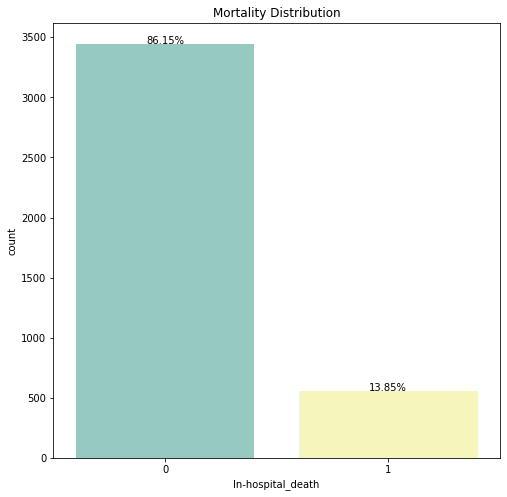

In [18]:
plt.figure(figsize = (8, 8))
ax = sns.countplot(df['In-hospital_death'])
plt.title('Mortality Distribution')
for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
                f"{round(100 * height / len(df), 2)}%",
                ha = 'center')

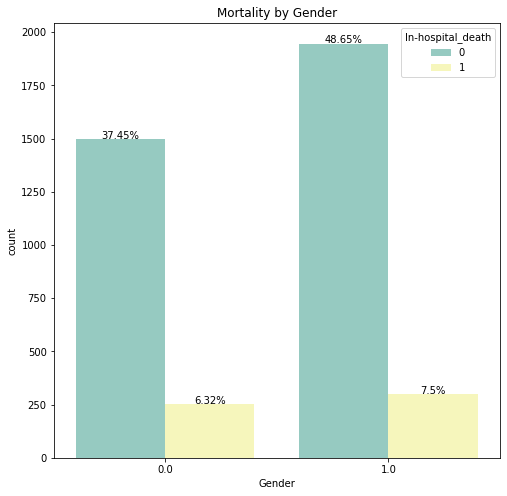

In [19]:
plt.figure(figsize = (8, 8))
plt.title('Mortality by Gender')
ax = sns.countplot(x = 'Gender', data = df, hue = 'In-hospital_death')
for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
                f"{round(100 * height / len(df), 2)}%",
                ha = 'center')

 - Mortality is almost same in both male and female patients

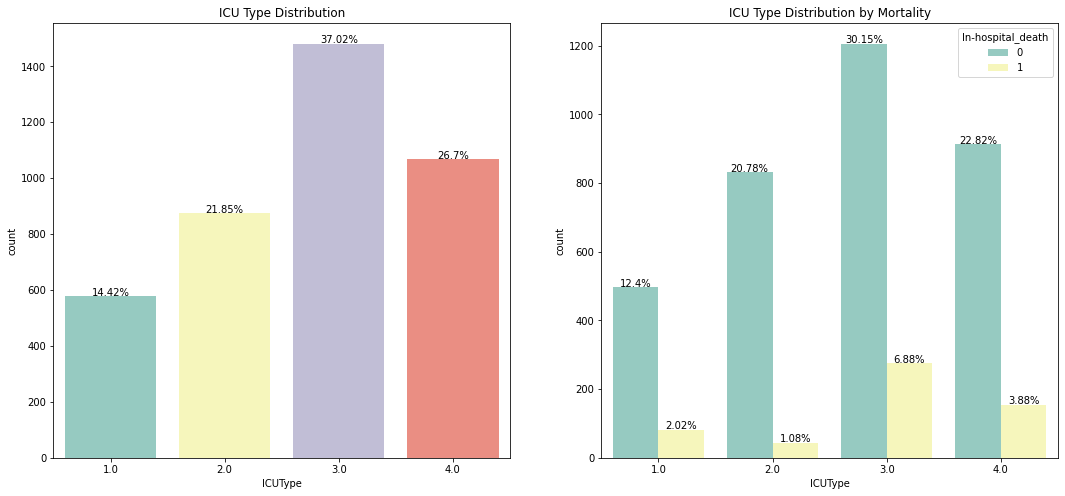

In [20]:
plt.figure(figsize = (18, 8))
plt.subplot(1, 2, 1)
plt.title('ICU Type Distribution')
ax = sns.countplot(x = 'ICUType', data = df)
for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
                f"{round(100 * height / len(df), 2)}%",
                ha = 'center')
        
plt.subplot(1, 2, 2)
plt.title('ICU Type Distribution by Mortality')
ax = sns.countplot(x = 'ICUType', data = df, hue = 'In-hospital_death')
for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
                f"{round(100 * height / len(df), 2)}%",
                ha = 'center')

- Mortality is higher in patients admitted in ICUType 

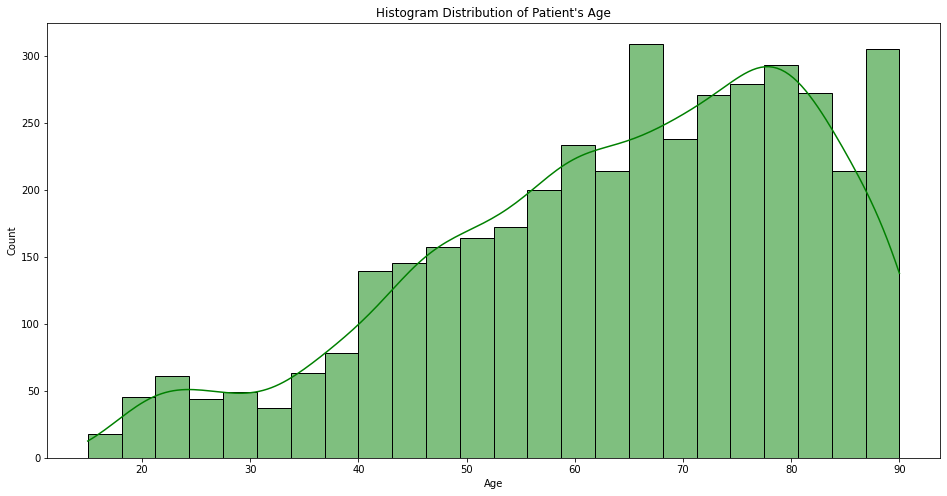

In [21]:
plt.figure(figsize = (16, 8))
plt.title("Histogram Distribution of Patient's Age")
sns.histplot(df['Age'], color = 'green', kde = True);

- Most of the ICU Patients are higher age group

#### Mortality by age group

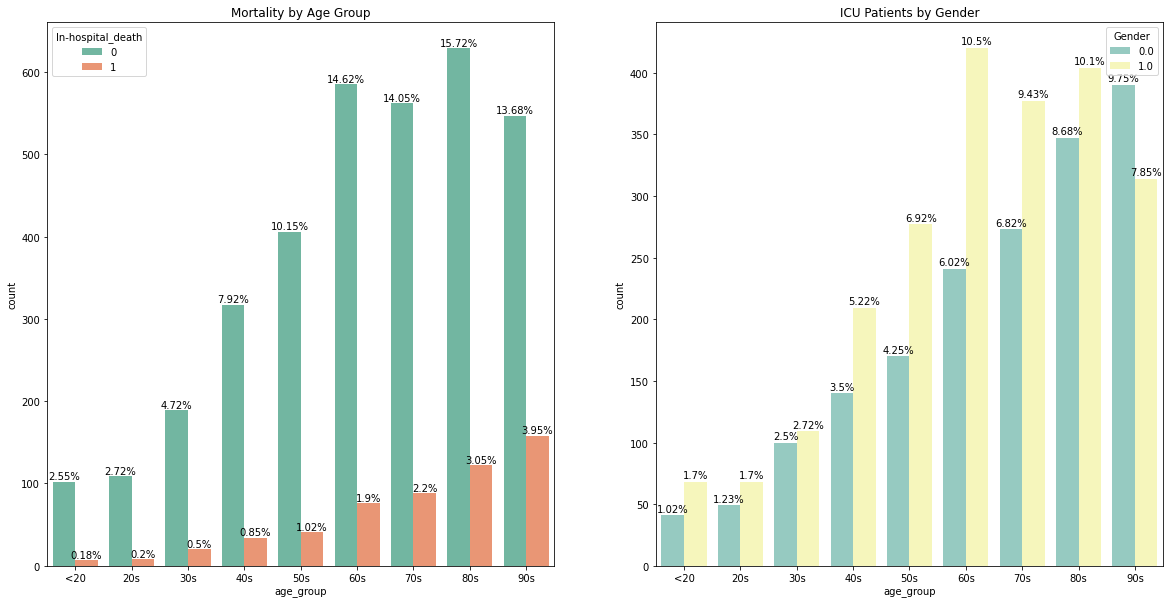

In [22]:
df['age_group'] = pd.cut(df['Age'], bins = 9, labels = ['<20', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s'])

plt.figure(figsize = (20, 10))
plt.subplot(1, 2, 1)
plt.title('Mortality by Age Group')
ax = sns.countplot(x = 'age_group', data = df, hue = 'In-hospital_death', palette = 'Set2')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
            f"{round(100 * height / len(df), 2)}%",
            ha = 'center')

plt.subplot(1, 2, 2)
plt.title('ICU Patients by Gender')
ax = sns.countplot(x = 'age_group', data = df, hue = 'Gender', palette = 'Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
            f"{round(100 * height / len(df), 2)}%",
            ha = 'center')

- Mortality is more for patients in higher age group
- More Male patients are in ICU than Female patients

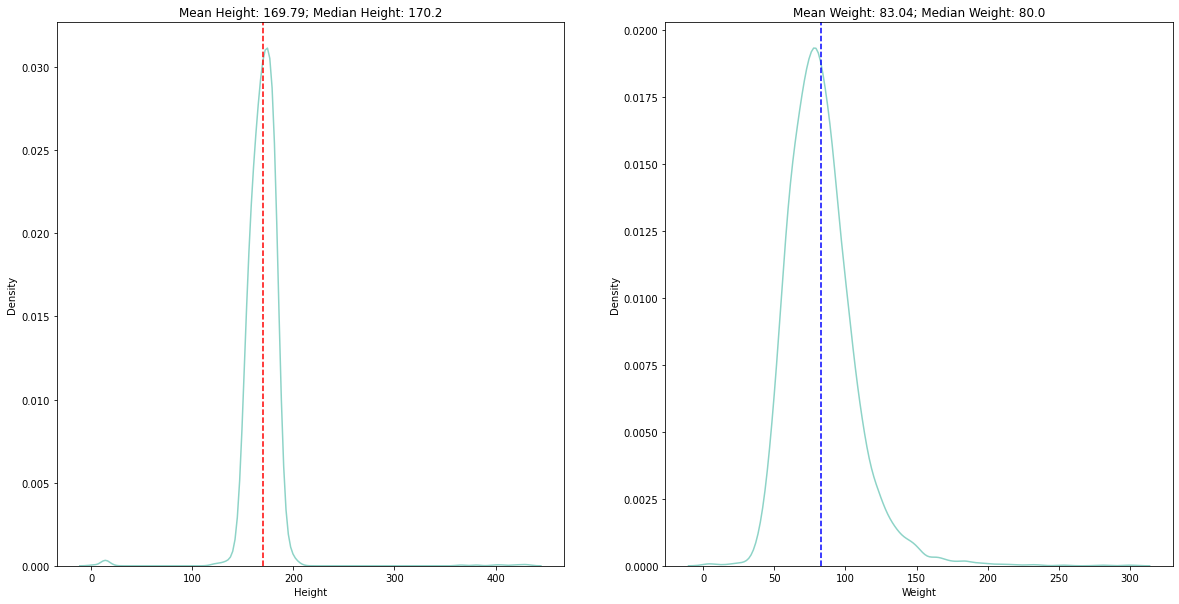

In [23]:
plt.figure(figsize = (20, 10))
plt.subplot(1, 2, 1)
plt.title(f"Mean Height: {round(df['Height'].mean(), 2)}; Median Height: {df['Height'].median()}")
ax = sns.kdeplot(x = 'Height', data = df)
ax.axvline(df['Height'].mean(), ls = '--', color = 'r')

plt.subplot(1, 2, 2)
plt.title(f"Mean Weight: {round(df['Weight'].mean(), 2)}; Median Weight: {df['Weight'].median()}")
ax = sns.kdeplot(x = 'Weight', data = df)
ax.axvline(df['Weight'].mean(), ls = '--', color = 'b')
plt.show()

- Now we calculate the Body Mass Index (BMI) of patients to check how it affects their mortality
- To calculate the BMI of patients in ICU we need impute NaNs in Height and Weight features
- We impute using their Median value
- The formula is BMI = kg/m2 where kg is a person's weight in kilograms and m2 is their height in metres squared
- Height in our dataset is in cm (centimeters) so the formula is __weight (kg) / [height (cm)]^2 x 10,000__

In [24]:
df['Height'] = df['Height'].fillna(df['Height'].median())
df['Weight'] = df['Weight'].fillna(df['Weight'].median())
df['bmi'] = df.apply(lambda x: round((x['Weight'] / (x['Height'] ** 2)) * 10000, 2), axis = 1)
df['bmi_group'] = pd.cut(df['bmi'], bins = [df['bmi'].min(), 18.5, 24.9, 29.9, df['bmi'].max()], labels = ['Underweight', 'Healthy', 'Overweight', 'Obesity'])

del df['bmi']
gc.collect()

17617

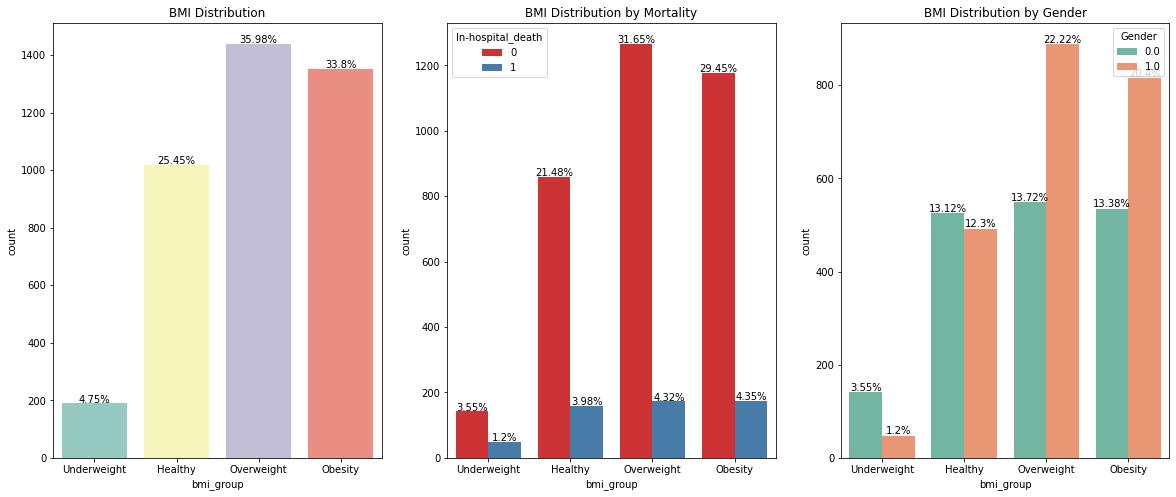

In [25]:
plt.figure(figsize = (20, 8))
plt.subplot(1, 3, 1)
plt.title('BMI Distribution')
ax = sns.countplot(df['bmi_group'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
            f"{round(100 * height / len(df), 2)}%",
            ha = 'center')

plt.subplot(1, 3, 2)
plt.title('BMI Distribution by Mortality')
ax = sns.countplot(x = 'bmi_group', data = df, hue = 'In-hospital_death', palette = 'Set1')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
            f"{round(100 * height / len(df), 2)}%",
            ha = 'center')

plt.subplot(1, 3, 3)
plt.title('BMI Distribution by Gender')
ax = sns.countplot(x = 'bmi_group', data = df, hue = 'Gender', palette = 'Set2')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
            f"{round(100 * height / len(df), 2)}%",
            ha = 'center')

- Around 70% of the patients admitted are in the bmi index 'Overweight' or 'Obese'
- Mortality is bit higher in both these categories
- Unhealthy bmi is higher in Male category

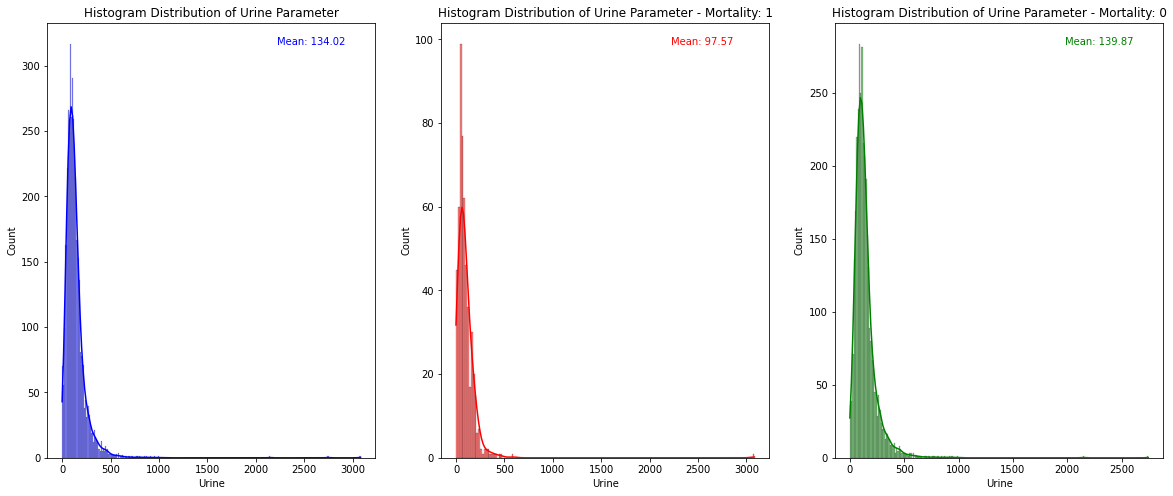

In [26]:
plt.figure(figsize = (20, 8))
plt.subplot(1, 3, 1)
plt.title('Histogram Distribution of Urine Parameter')
sns.histplot(df['Urine'], color = 'blue', kde = True)
#plt.axvline(df['Urine'].mean(), ls = '--', color = 'y')
plt.annotate(f"Mean: {round(df['Urine'].mean(), 2)}", xy = (0.7, 0.95), xycoords = 'axes fraction', color = 'blue')
plt.subplot(1, 3, 2)
plt.title('Histogram Distribution of Urine Parameter - Mortality: 1')
sns.histplot(df[df['In-hospital_death'] == 1]['Urine'], color = 'red', kde = True)
plt.annotate(f"Mean: {round(df[df['In-hospital_death'] == 1]['Urine'].mean(), 2)}", xy = (0.7, 0.95), xycoords = 'axes fraction', color = 'red')
plt.subplot(1, 3, 3)
plt.title('Histogram Distribution of Urine Parameter - Mortality: 0')
sns.histplot(df[df['In-hospital_death'] == 0]['Urine'], color = 'green', kde = True)
plt.annotate(f"Mean: {round(df[df['In-hospital_death'] == 0]['Urine'].mean(), 2)}", xy = (0.7, 0.95), xycoords = 'axes fraction', color = 'green');

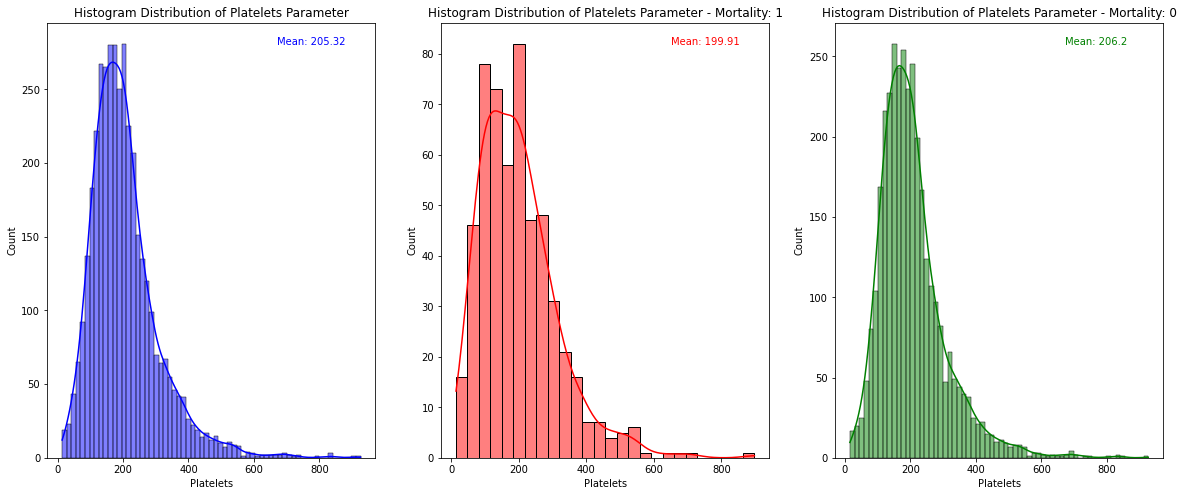

In [27]:
plt.figure(figsize = (20, 8))
plt.subplot(1, 3, 1)
plt.title('Histogram Distribution of Platelets Parameter')
sns.histplot(df['Platelets'], color = 'blue', kde = True)
plt.annotate(f"Mean: {round(df['Platelets'].mean(), 2)}", xy = (0.7, 0.95), xycoords = 'axes fraction', color = 'blue')
plt.subplot(1, 3, 2)
plt.title('Histogram Distribution of Platelets Parameter - Mortality: 1')
sns.histplot(df[df['In-hospital_death'] == 1]['Platelets'], color = 'red', kde = True)
plt.annotate(f"Mean: {round(df[df['In-hospital_death'] == 1]['Platelets'].mean(), 2)}", xy = (0.7, 0.95), xycoords = 'axes fraction', color = 'red')
plt.subplot(1, 3, 3)
plt.title('Histogram Distribution of Platelets Parameter - Mortality: 0')
sns.histplot(df[df['In-hospital_death'] == 0]['Platelets'], color = 'green', kde = True)
plt.annotate(f"Mean: {round(df[df['In-hospital_death'] == 0]['Platelets'].mean(), 2)}", xy = (0.7, 0.95), xycoords = 'axes fraction', color = 'green');

In [28]:
cat_features = ['Gender', 'ICUType', 'age_group', 'bmi_group']
num_features = [c for c in df.columns if c not in cat_features]
num_features = [c for c in num_features if c not in ['RecordID', 'In-hospital_death']]
cat_features, num_features

(['Gender', 'ICUType', 'age_group', 'bmi_group'],
 ['Age',
  'Height',
  'Weight',
  'Urine',
  'HR',
  'Temp',
  'NIDiasABP',
  'SysABP',
  'DiasABP',
  'pH',
  'PaCO2',
  'PaO2',
  'Platelets',
  'MAP',
  'K',
  'Na',
  'FiO2',
  'GCS'])

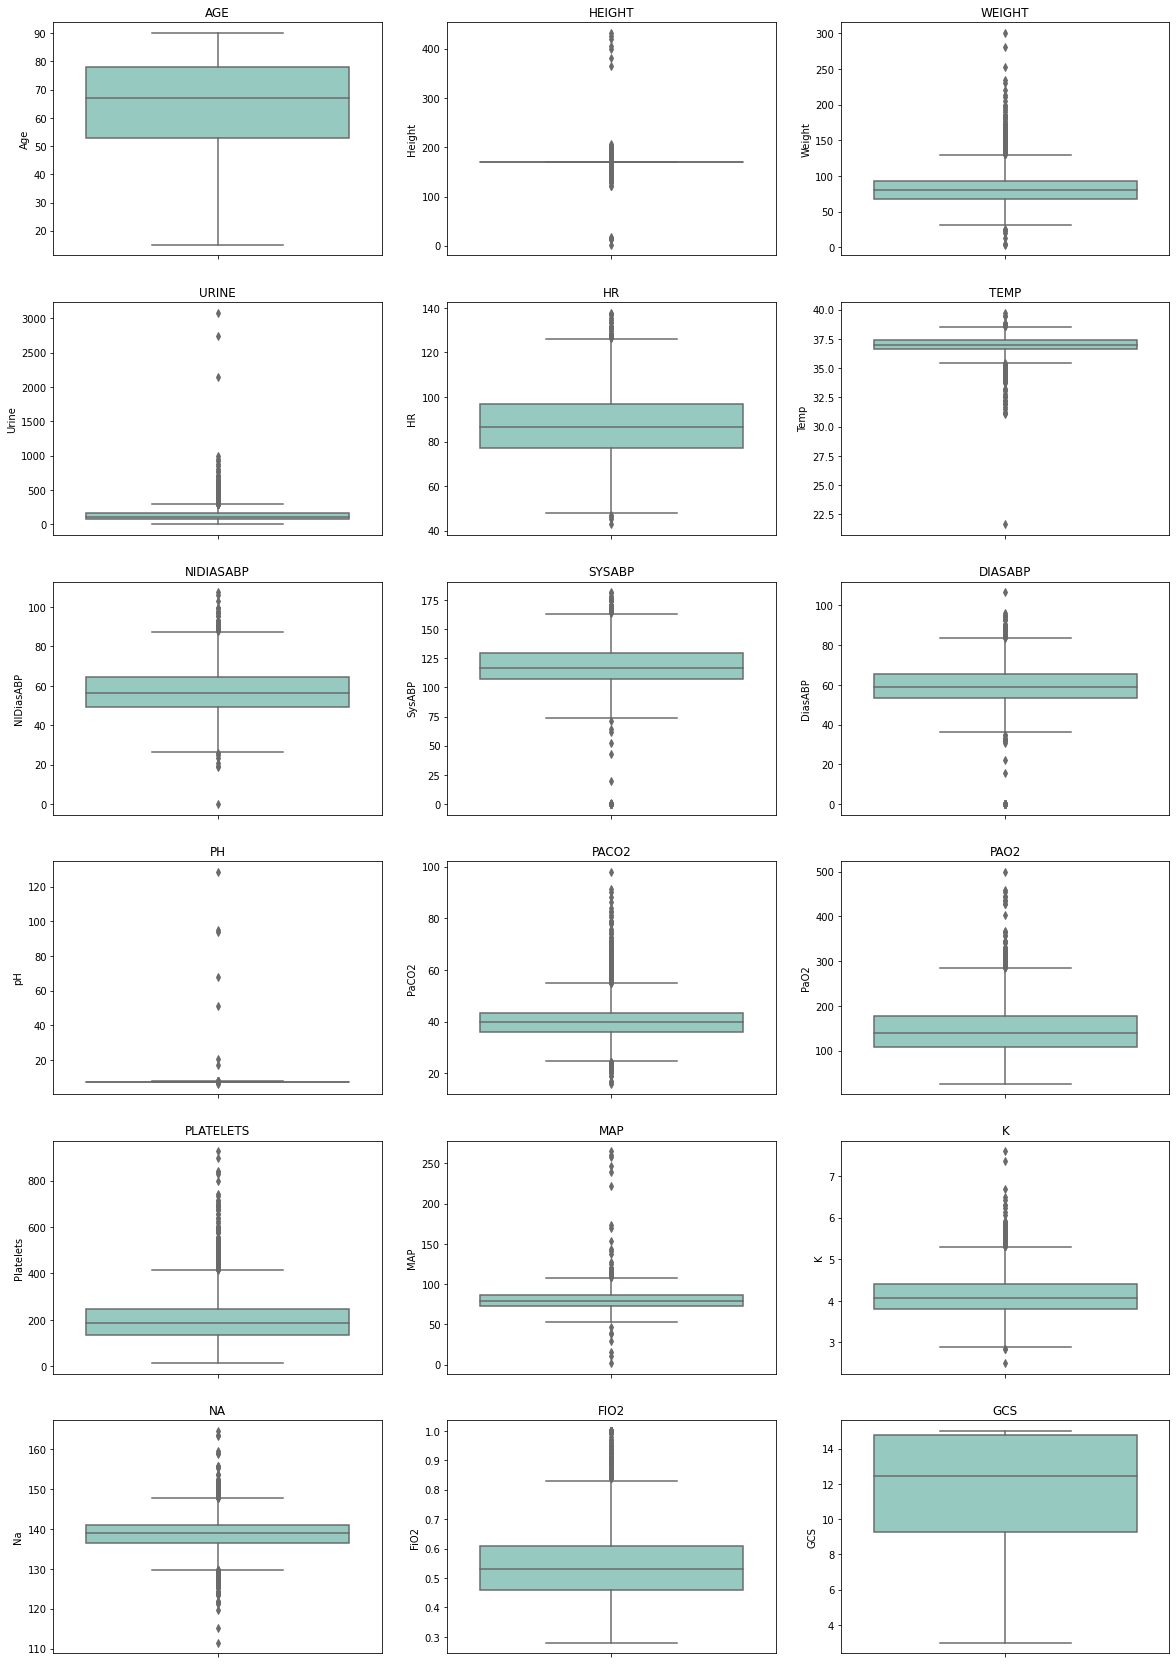

In [29]:
plt.figure(figsize = (20, 30))
for i, col in enumerate(df[num_features]):
    plt.subplot(6, len(num_features) / 6, i + 1)
    sns.boxplot(y = col, data = df)
    plt.title(col.upper())
    

- Most of the features have outliers

### NaN Imputation
- Before proceeding with modeling and prediction we will have to impute the NaN values in the dataset
- We can impute all the NaNs with the respective feature's mean value
- But here we impute NaNs depending on the 'In-hospital_death' value

In [30]:
df_0 = df[df['In-hospital_death'] == 0].copy()
df_1 = df[df['In-hospital_death'] == 1].copy()
#Impute Numerical Features with mean value
df_0[num_features] = df_0[num_features].fillna(df_0[num_features].mean())
df_1[num_features] = df_1[num_features].fillna(df_1[num_features].mean())

#Impute Categorical Features with most frequent value
for col in cat_features:
    df_0[col] = df_0[col].fillna(df_0[col].value_counts().index[0])
    df_1[col] = df_1[col].fillna(df_1[col].value_counts().index[0])

#concat both df, shuffle and reset index
df = pd.concat([df_0, df_1], axis = 0).sample(frac = 1).reset_index(drop = True)
df.shape

(4000, 24)

In [31]:
print('Feature Correlation with target:')
df.corr()['In-hospital_death']

Feature Correlation with target:


RecordID            -0.011532
Age                  0.130700
Gender              -0.015298
Height              -0.013628
Weight              -0.054590
Urine               -0.124613
HR                   0.073804
Temp                -0.060020
NIDiasABP           -0.092156
SysABP              -0.066522
DiasABP             -0.075264
pH                   0.027736
PaCO2               -0.095989
PaO2                -0.100565
Platelets           -0.021218
MAP                 -0.032995
K                    0.022389
Na                   0.022402
FiO2                 0.052473
GCS                 -0.256609
ICUType              0.059896
In-hospital_death    1.000000
Name: In-hospital_death, dtype: float64

### Label Encoding & Standardization

- __Standardization__: Handle outliers better; Mean 0, Std: 1
- __Normalization__: Doesn't handle outliers well; 0 to 1 Range

In [32]:
#Label Encoding age, gender, category
for col in ['Gender', 'ICUType', 'age_group', 'bmi_group']:
    print(f"Label Encoding: {col} - {df[col].nunique()}")
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

Label Encoding: Gender - 2
Label Encoding: ICUType - 4
Label Encoding: age_group - 9
Label Encoding: bmi_group - 4


In [33]:
std = StandardScaler()
df[num_features] = std.fit_transform(df[num_features])

In [34]:
X = df.drop(['RecordID', 'In-hospital_death'], axis = 1)
y = df['In-hospital_death'].copy()

In [35]:
#scale_pos_weight - sample Weights
num_pos_samples = y.value_counts().values[1]
num_neg_samples = y.value_counts().values[0]

class_weight = num_neg_samples / num_pos_samples
print(f"scale_pos_weight:")
num_neg_samples / num_pos_samples, np.sqrt(num_neg_samples / num_pos_samples)

scale_pos_weight:


(6.2202166064981945, 2.4940362079364835)

## When to use PR AUC?
#### When two classes are equally important
AUC would be the metric to use if the goal of the model is to perform equally well on both classes. Image classification between cats & dogs is a good example because the performance on cats is equally important on dogs.

#### When minority class is more important
PR AUC would be the metric to use if the focus of the model is to identify correctly as many positive samples as possible.

# Precision-Recall Curve
Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. __A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.__ High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

[Ref](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

In [36]:
def plot_pr_curve(precision, recall, avg_precision):
    plt.figure(figsize = (8, 6))
    plt.plot(recall, precision, label = f"Avg. PR: {round(avg_precision, 2)}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.5, 1.05])
    plt.xlim([0.55, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

In [37]:
def plot_confusion(mat):
    plt.figure(figsize = (8, 4))
    sns.heatmap(pd.DataFrame(mat), annot = True, annot_kws = {"size": 25}, cmap = 'Blues', fmt = 'g')
    plt.title('Confusion matrix', y = 1.1, fontsize = 22)
    plt.ylabel('Actual', fontsize = 18)
    plt.xlabel('Predicted', fontsize = 18)
    plt.show()

In [38]:
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

xgb_params = {
         'objective': 'binary:logistic',
         'lambda': 0.0030282073258141168, 
         'alpha': 0.01563845128469084,
         'colsample_bytree': 0.55,
         'subsample': 0.7,
         'learning_rate': 0.01,
         'max_depth': 9,
         'random_state': 2020, 
         'min_child_weight': 257,
         'eval_metric': 'aucpr',
         'seed': 2021,
         'scale_pos_weight': num_neg_samples / num_pos_samples #np.sqrt(num_neg_samples / num_pos_samples)
         }

In [39]:
import lightgbm as lgbm

params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': None,
        'learning_rate': 0.02,
        'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': -1
}

def pr_score(preds, train_data):
    aps = average_precision_score(train_data.get_label(), preds)
    return 'aps', aps, False

In [40]:
def compute_precision_recall(conf_mat):
    #compute precision and recall
    tp_and_fn = conf_mat.sum(axis = 1)
    tp_and_fp = conf_mat.sum(axis = 0)
    tp = conf_mat.diagonal()
    precision = tp / tp_and_fp
    recall = tp / tp_and_fn
    return precision, recall

In [41]:
model_type = 'xgbclassifier'

###########################################################################################
Fold: 1
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.721361350230372


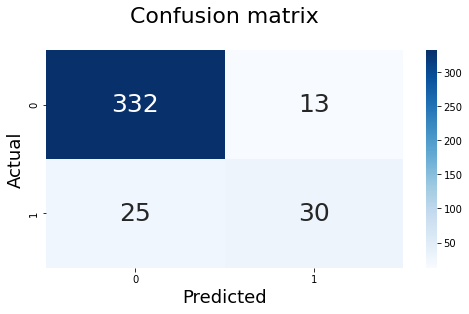

Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       345
           1       0.70      0.55      0.61        55

    accuracy                           0.91       400
   macro avg       0.81      0.75      0.78       400
weighted avg       0.90      0.91      0.90       400


###########################################################################################
Fold: 2
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.8197604211508516


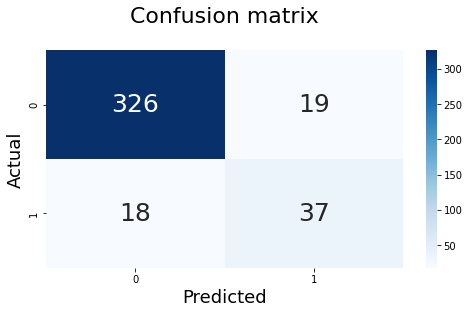

Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       345
           1       0.66      0.67      0.67        55

    accuracy                           0.91       400
   macro avg       0.80      0.81      0.81       400
weighted avg       0.91      0.91      0.91       400


###########################################################################################
Fold: 3
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.7865326002706072


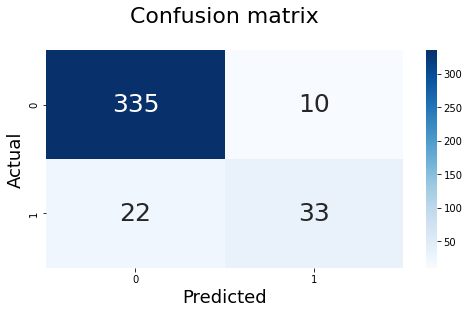

Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       345
           1       0.77      0.60      0.67        55

    accuracy                           0.92       400
   macro avg       0.85      0.79      0.81       400
weighted avg       0.91      0.92      0.92       400


###########################################################################################
Fold: 4
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.825526365784452


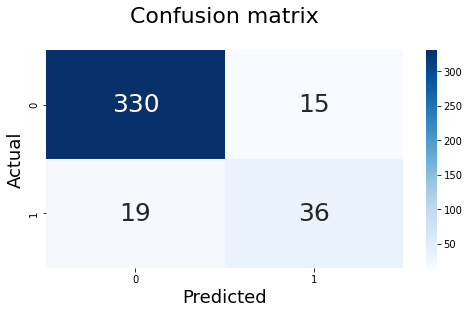

Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       345
           1       0.71      0.65      0.68        55

    accuracy                           0.92       400
   macro avg       0.83      0.81      0.82       400
weighted avg       0.91      0.92      0.91       400


###########################################################################################
Fold: 5
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.7162797356417099


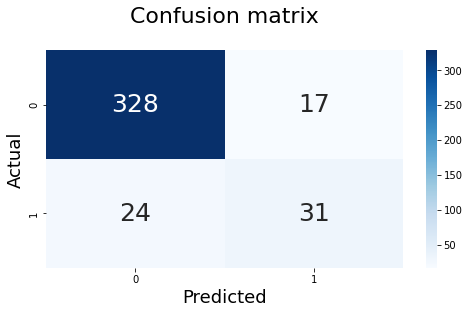

Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       345
           1       0.65      0.56      0.60        55

    accuracy                           0.90       400
   macro avg       0.79      0.76      0.77       400
weighted avg       0.89      0.90      0.89       400


###########################################################################################
Fold: 6
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.8425382988333794


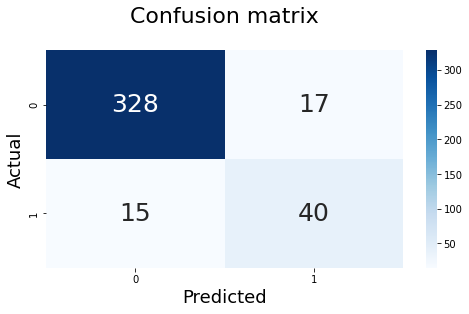

Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       345
           1       0.70      0.73      0.71        55

    accuracy                           0.92       400
   macro avg       0.83      0.84      0.83       400
weighted avg       0.92      0.92      0.92       400


###########################################################################################
Fold: 7
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.7795999312330261


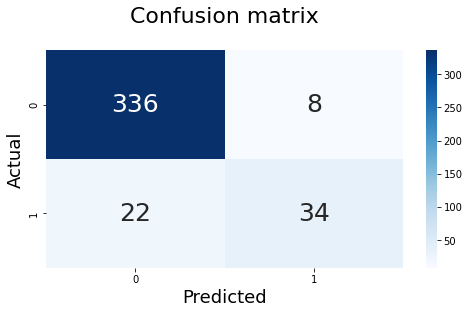

Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       344
           1       0.81      0.61      0.69        56

    accuracy                           0.93       400
   macro avg       0.87      0.79      0.83       400
weighted avg       0.92      0.93      0.92       400


###########################################################################################
Fold: 8
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.7827501263114806


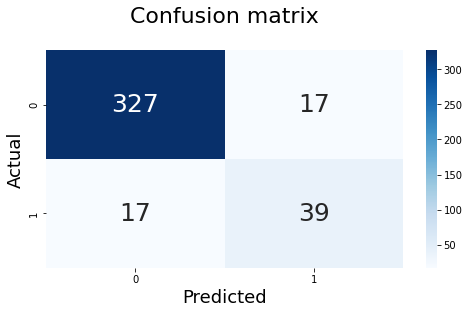

Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       344
           1       0.70      0.70      0.70        56

    accuracy                           0.92       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.92      0.92      0.92       400


###########################################################################################
Fold: 9
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.7534380972627224


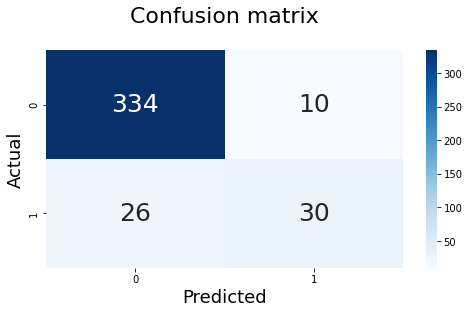

Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       344
           1       0.75      0.54      0.63        56

    accuracy                           0.91       400
   macro avg       0.84      0.75      0.79       400
weighted avg       0.90      0.91      0.90       400


###########################################################################################
Fold: 10
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################

Avg. Precision-Recall Score: 0.8179509641524833


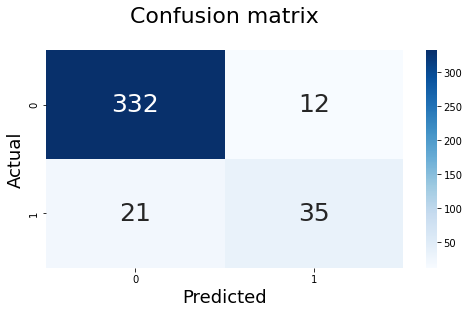

Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       344
           1       0.74      0.62      0.68        56

    accuracy                           0.92       400
   macro avg       0.84      0.80      0.82       400
weighted avg       0.91      0.92      0.91       400




In [42]:
n_folds = 10
preds_xg = []
overall_pr = []
all_precision, all_recall = [], []

skf = StratifiedKFold(n_splits = n_folds)
#rkf = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 5, random_state = 42)

for i, (trn_idx, val_idx) in enumerate(skf.split(X, y)):
    print('#############' * 7)
    print(f"Fold: {i + 1}")
    Xtrain, ytrain = X.iloc[trn_idx], y[trn_idx]
    Xvalid, yvalid = X.iloc[val_idx], y[val_idx]
    print(Xtrain.shape, ytrain.shape, Xvalid.shape, yvalid.shape)
    print(f"Classifier: {model_type}")
    print('#############' * 7)
    
    if model_type == 'lgbm':
        ltrain = lgbm.Dataset(Xtrain, label = ytrain)
        lvalid = lgbm.Dataset(Xvalid, label = yvalid)

        model = lgbm.train(params,
                ltrain,
                num_boost_round = 2000,
                valid_sets = [ltrain, lvalid],
                verbose_eval = 250,
                early_stopping_rounds = 100, 
                feval = pr_score)

        valid_preds = model.predict(Xvalid)
        
    if model_type == 'xgboost':
        xg_train = xgb.DMatrix(Xtrain, label = ytrain)
        xg_valid = xgb.DMatrix(Xvalid, label = yvalid)

        clf = xgb.train(params,
                          xg_train,
                          5000,
                          verbose_eval = 50,
                          evals = [(xg_train, 'train'), (xg_valid, 'valid')],
                          early_stopping_rounds = 100
                       )

        valid_preds = clf.predict(xg_valid)
    
    if model_type == 'xgbclassifier':
        clf = XGBClassifier(scale_pos_weight = class_weight, eval_metric = 'aucpr',
                                random_state = 42, n_jobs = -1)
        clf.fit(Xtrain, ytrain)
        valid_preds = clf.predict_proba(Xvalid)[:, 1]
        
    avg_precision = average_precision_score(yvalid, valid_preds)
    print(f'\nAvg. Precision-Recall Score: {avg_precision}')
    overall_pr.append(avg_precision)
    
    #precision, recall, _ = precision_recall_curve(yvalid, valid_preds)
    #plot_pr_curve(precision, recall, avg_precision)
    
    conf_mat = confusion_matrix(yvalid, valid_preds > 0.5)
    #compute precision and recall
    pre, rec = compute_precision_recall(conf_mat)
    all_precision.append(pre)
    all_recall.append(rec)
    plot_confusion(conf_mat)
    
    print(f"Classification Report: \n{classification_report(yvalid, valid_preds > 0.5, labels = [0, 1])}")
    
    preds_xg.append(valid_preds)
    #plot_importance(clf)
    print()

In [43]:
print(f"Overall Avg CV Score: {np.mean(overall_pr)}")
print(f"Avg. Precision: {np.mean(all_precision)}\nAvg. Recall: {np.mean(all_recall)}")

Overall Avg CV Score: 0.7845737890871083
Avg. Precision: 0.8293508671700875
Avg. Recall: 0.7913763027501652


In [44]:
display(HTML(f"<h1></b>- Precision at {round(np.mean(all_precision) * 100, 2)}% means that when our model predicts the mortality it is correct {round(np.mean(all_precision) * 100, 2)}% of the time </b></h1>"))
display(HTML(f"<h1></b>- Recall at {round(np.mean(all_recall) * 100, 2)}% means that our model correctly identifies {round(np.mean(all_recall) * 100, 2)}% of all mortality in patients </b></h1>"))

# Model Explainability by SHAP

Thanks to this excellent [Notebook](https://www.kaggle.com/bextuychiev/model-explainability-with-shap-only-guide-u-need)

In [45]:
%%time
import shap

#Shap values with XGBoost core model
#Getting the shap values using the model is faster than usual way
booster_xgb = clf.get_booster()
shap_values_xgb = booster_xgb.predict(xgb.DMatrix(Xtrain, ytrain), pred_contribs = True)

2021-12-20 03:18:57.320771: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-20 03:18:57.320915: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


CPU times: user 6.14 s, sys: 675 ms, total: 6.82 s
Wall time: 7.61 s


In [46]:
shap_values_xgb = shap_values_xgb[:, :-1]
print(shap_values_xgb.shape)
pd.DataFrame(shap_values_xgb, columns = Xtrain.columns.tolist()).head()

(3600, 22)


,Age,Gender,Height,Weight,Urine,HR,Temp,NIDiasABP,SysABP,DiasABP,...,PaO2,Platelets,MAP,K,Na,FiO2,GCS,ICUType,age_group,bmi_group
0,-1.864820,0.027125,-0.119964,-0.162826,-0.728509,0.069467,-0.312244,-0.147880,-0.193434,-0.174824,...,-0.026408,-0.489717,-0.039927,-0.826131,-0.294827,-0.366713,1.620603,0.164161,0.021331,-0.001094
1,-0.229722,0.054734,-0.374913,-0.293748,-0.746750,0.192466,-0.425091,-0.549328,-1.217848,-0.458110,...,-0.096135,0.094917,-0.134795,-0.648766,-0.355963,-0.160486,-1.631363,-0.719340,0.004273,-0.095481
2,-0.644586,0.035411,-0.118475,-0.194419,-0.042651,-0.413105,-0.446887,-0.618817,-1.008636,-0.060793,...,-0.934175,-0.300771,-0.350804,-0.311842,-0.458739,-0.593478,-1.728070,-1.011932,-0.005060,0.015582
3,-1.313730,0.070245,-0.083227,-0.172638,-0.418218,0.374748,-0.491401,-0.252053,0.190034,-0.212691,...,-0.957714,-0.130119,0.027433,0.025658,-0.187743,-2.009058,-2.115070,-0.369646,-0.012689,-0.098506
4,-0.168232,0.033214,-0.077362,-0.067808,-0.793342,-0.024082,-0.115925,0.107648,-1.880958,-0.884848,...,-0.805150,-0.404414,-1.012704,0.001173,0.080546,-2.168063,-1.622460,0.234370,0.002609,0.001777


# Feature Importances

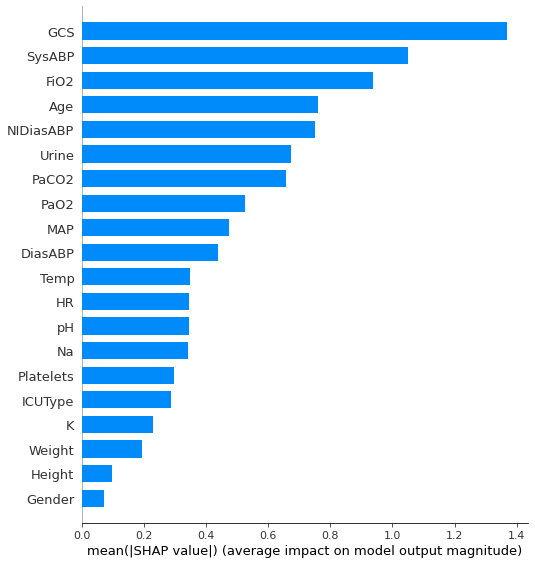

In [47]:
shap.summary_plot(shap_values_xgb, Xtrain, feature_names = Xtrain.columns, plot_type = "bar")

In [48]:
#importances are just the average absolute Shapley values for a feature. We can check that below:
pd.DataFrame(shap_values_xgb, columns = Xtrain.columns)["GCS"].abs().mean()

1.3676259517669678

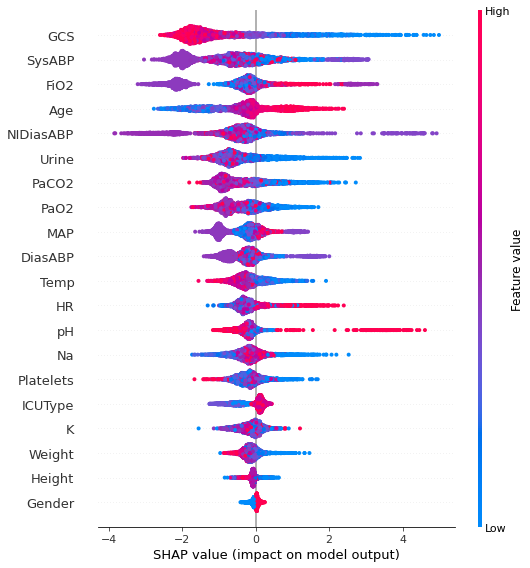

In [49]:
shap.summary_plot(shap_values_xgb, Xtrain, feature_names = Xtrain.columns);

- The left vertical axis denotes feature names, ordered based on importance from top to bottom.
- The horizontal axis represents the magnitude of the SHAP values for predictions.
- The vertical right axis represents the actual magnitude of a feature as it appears in the dataset and colors the points.

We see that as GCS increases, its effect on the model is more positive.

In [50]:
%%time

#SHAP interactions with XGB
interactions_xgb = booster_xgb.predict(xgb.DMatrix(Xtrain, ytrain), pred_interactions = True)
interactions_xgb.shape

CPU times: user 2min 34s, sys: 30.9 ms, total: 2min 34s
Wall time: 39.3 s


(3600, 23, 23)

## Top K Interactions between features

[Thanks to tunguz](https://www.kaggle.com/tunguz)

In [51]:
def get_top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                    (
                        feature_names[i] + "-" + feature_names[j],
                        aggregate_interactions[i][j] * 2,
                    )
                )
    # sort by magnitude
    interactions.sort(key = lambda x: x[1], reverse = True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))

    return interaction_features[:k], interaction_values[:k]


top_10_inter_feats, top_10_inter_vals = get_top_k_interactions(Xtrain.columns, interactions_xgb, 10)

In [52]:
top_10_inter_feats

('GCS-PaO2',
 'Na-NIDiasABP',
 'GCS-SysABP',
 'GCS-NIDiasABP',
 'DiasABP-SysABP',
 'GCS-FiO2',
 'PaO2-PaCO2',
 'GCS-PaCO2',
 'PaO2-SysABP',
 'Urine-Age')

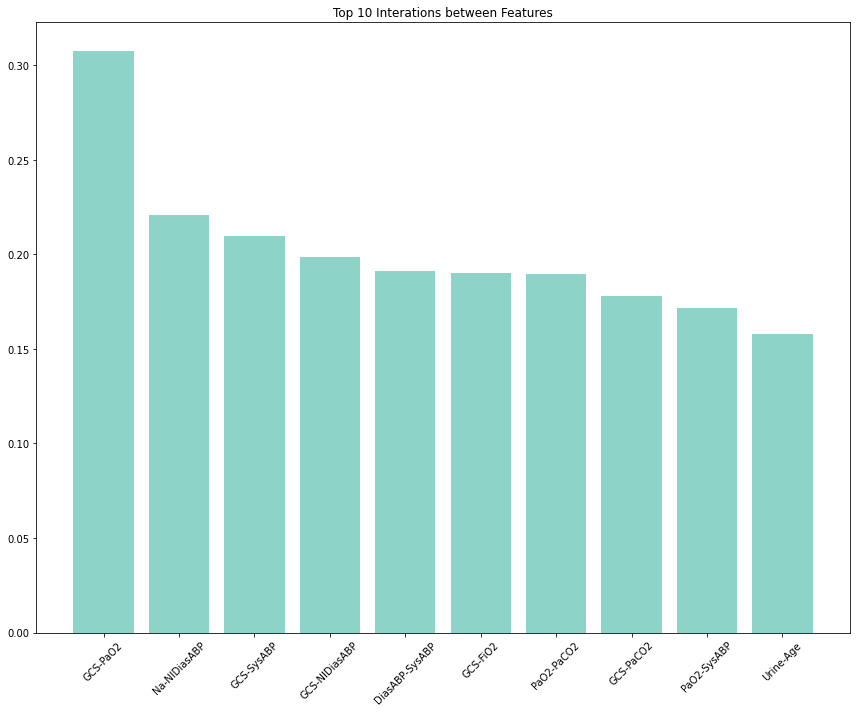

In [53]:
def plot_interaction_pairs(pairs, values):
    plt.bar(pairs, values)
    plt.xticks(rotation = 45)
    plt.title('Top 10 Interations between Features')
    plt.tight_layout()
    plt.show()
    
top_10_inter_feats, top_10_inter_vals = get_top_k_interactions(Xtrain.columns, interactions_xgb, 10)

plot_interaction_pairs(top_10_inter_feats, top_10_inter_vals)

- GCS feature interacts with most of the other feautures

# Local Interpretability
[Ref](https://www.kaggle.com/bextuychiev/model-explainability-with-shap-only-guide-u-need#Summary)

In [54]:
random_idx = np.random.randint(len(Xtrain))
random_idx

583

In [55]:
%%time
#Create a tree explainer
xgb_explainer = shap.TreeExplainer(clf, Xtrain, feature_names = Xtrain.columns.tolist())

#Recalculate SHAP values
shap_explainer_values = xgb_explainer(Xtrain, ytrain)

 94%|=================== | 3385/3600 [00:15<00:00]       

CPU times: user 15.6 s, sys: 38.6 ms, total: 15.6 s
Wall time: 15.6 s


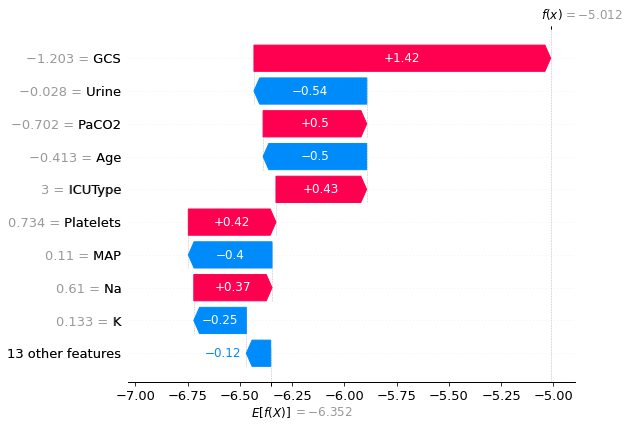

In [56]:
shap.waterfall_plot(shap_explainer_values[random_idx])

The thin line in the middle denotes the mean prediction. The vertical axis shows the feature values of the random_idx. The bars represent how each feature property shifted the prediction from the mean prediction. The red bars represent positive shifts; the blue bars represent negative shifts.

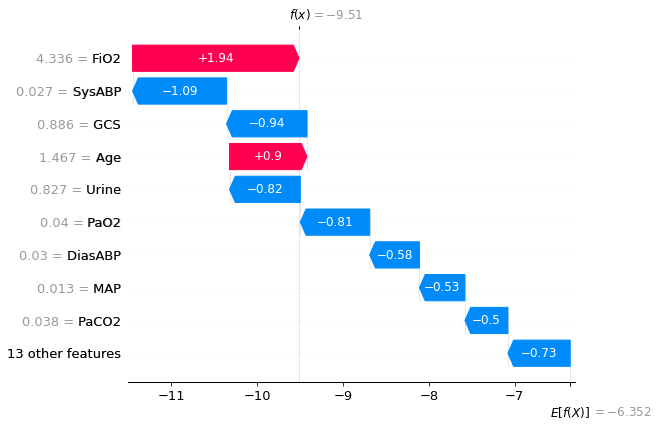

In [57]:
shap.waterfall_plot(shap_explainer_values[100])

- The waterfall_plot above is same as the Shap Force plot
- Features in red push the prediction to postive - 1 while the features in blue makes the prediction move towards 0